# Поиск выбросов (outliers)

In [1]:
import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt
%matplotlib inline

vis_data = pd.read_csv("train.csv", 
                       encoding = 'ISO-8859-1', 
                       low_memory = False)
vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis=1)
latlons = pd.read_csv("latlons.csv")
vis_data = pd.concat([vis_data, latlons], axis=1)

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

vis_data['distance'] = vis_data.apply(lambda row: 
                                      haversine(lon1 = -83.045753, 
                                                lat1 = 42.331429,
                                                lon2 = row['lon'], 
                                                lat2 = row['lat']), 
                                      axis=1)

## Поиск и удаление по порогу

Часто оказывается так, что при погружении в предметную область вы начинаете понимать, какие значения данные признаки могут принимать, а какие - не могут. Например, если нужно заплатить штраф, полезно будет проверить, нет ли в выборке значений штрафов, меньших, чем `0`:

In [2]:
np.sum(vis_data.fine_amount < 0)

0

Кроме этого, интересно посмотреть максимальное значение штрафа:

In [3]:
max_fine = np.max(vis_data.fine_amount)
max_fine

10000.0

И сколько раз и как часто такой штраф встречается в данных:

In [4]:
max_fine_count = np.sum(vis_data.fine_amount == max_fine)
max_fine_count, max_fine_count/vis_data.shape[0]

(357, 0.0014262542647799094)

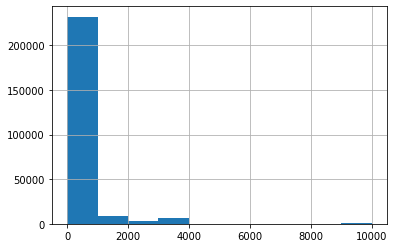

In [5]:
vis_data.fine_amount.hist();

Очень большое количество данных сосредоточено около 0. Посмотрим, сколько значений штрафов в выборке равно 0:

In [6]:
vis_data[vis_data.fine_amount == 0].shape[0]

195

In [8]:
np.sum(vis_data.fine_amount ==0)

195

Возможно, те значения, где размер штрафа равен 0, являются выбросами, если инспектор забыл добавить размер штрафа или ошибся при вводе.  
В таком случае эти значения следует убрать из выборки. В то же время, сложно однозначно сделать такое решение, не зная всей информации о данных.

Теперь посмотрим на данные поближе:

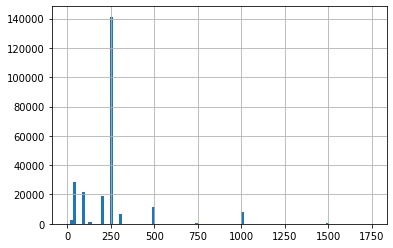

In [7]:
vis_data.fine_amount[vis_data.fine_amount < 2000].hist(bins=100);

Непохоже, что здесь есть выбросы (кроме нулевых штрафов), но можно категоризировать данные, заменив все значения больше 2000 на переменную `>2000` и сделав все остальные значения категориальными.

## Поиск по отклонению (z-score)
[Источник](http://colingorrie.github.io/outlier-detection.html)

Есть еще один способ поиска выбросов, не требующий настолько же пристального взгляда на данные, что и предыдущий метод.  
Он основан на поиске значения, на которое отклоняется данная точка от среднего. Делается это с помощью z-score, то есть, расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек.  
Для начала посмотрим на распределение данных для признака `distance`, который мы посчитали ранее:

In [9]:
import warnings

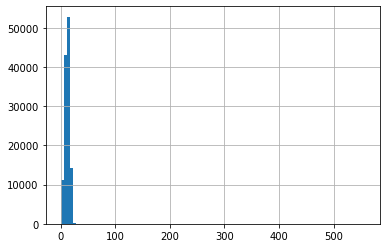

In [10]:
vis_data.distance.hist(bins=100);

Попытаемся "на глаз" определить порог, после которого мы считаем выбросы. Применим этот порог и посмотрим на количество "выбросов":

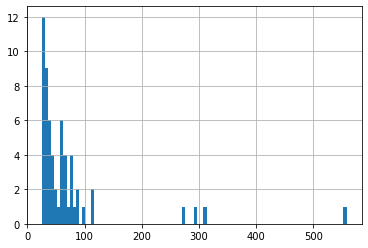

In [33]:
vis_data.distance[vis_data.distance > 25].hist(bins=100);

In [12]:
vis_data.distance[vis_data.distance > 30].shape[0]

51

In [13]:
np.sum(vis_data.distance > 30)

51

In [19]:
def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    o = outliers_z_score(vis_data.distance.dropna(), threshold=3)
len(o)

55

In [22]:
vis_data[vis_data.distance > 150].distance.value_counts()

311.995338    1
557.825576    1
293.408521    1
275.624714    1
Name: distance, dtype: int64

In [36]:
vis_data.distance.iloc[o]

1007       62.088424
2879       37.639754
4170       62.088424
6726      111.563487
7861       63.553117
8831       78.464792
12314      44.847663
16177      39.131558
16820      62.088424
17178      35.807193
17976      51.789290
20861      36.444818
21610      87.966019
22131      51.182274
22516      26.306244
23047      34.442729
23333      35.189650
24527      33.528915
30538      74.936842
31974      44.769420
33767      66.019912
41553      35.404428
46820      38.978889
48931     293.408521
49435      63.553117
53829      64.999441
58451      26.679719
59437      78.463745
59619      33.156718
62611     557.825576
63120      69.801890
63649      44.645816
66380      61.630363
67084      52.334592
68221      62.088424
73455      41.431107
74397      27.261079
74614      39.137273
77930      36.056226
80950      29.460300
83770      33.127428
84852      87.966908
89127      42.901880
89646      62.088424
89680      79.068298
90244      30.363322
90608      97.114710
92528      34

In [28]:
np.mean(vis_data.distance)

11.553137744120818

In [34]:
np.std(vis_data.distance)

4.892749096433584

In [35]:
np.mean(vis_data.distance) + 3*np.std(vis_data.distance)

26.23138503342157

In [37]:
np.sum(vis_data.distance>26.231385)

55

In [21]:
len(o)

55

Значение по умолчанию для функции поиска выбросов равно `3`. Это означает, что мы считаем выбросами все, что находится на расстоянии больше 3 стандартных отклонений от среднего. Если мы подвигаем этот параметр в большую или меньшую сторону, мы найдем меньше или больше выбросов.

## IQR (interquartile range, межквартильное расстояние)

Один из способов - использовать перцентили (в данном случае квартили) для определения, где находятся выбросы. Для начала, посмотрим на `boxplot` для признака `distance`. Данный вид графика делит данные на 4 части. Та часть данных, которая отделена слева и справа двумя вертикальными линиями (находится внутри коробки) содержит 50% данных, так как левая линия обозначает первый квартиль (25-й перцентиль), а правая линия обозначает третий квартиль (75-й перцентиль).  
Большой вертикальной линией выделена медиана:

In [44]:
import seaborn as sns

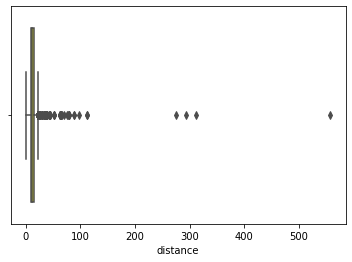

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.boxplot(vis_data.distance, color='yellow');

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами коробки.  
Посмотрим, сколько выбросов он найдет:

In [47]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

Данный метод чувствителен к пропускам, поэтому избавимся от них:

In [52]:
o = outliers_iqr(vis_data.distance.dropna())

In [53]:
len(o)

134

In [56]:
np.percentile(vis_data.distance.dropna(), [25,75])

array([ 8.50142166, 14.2610284 ])

<AxesSubplot:>

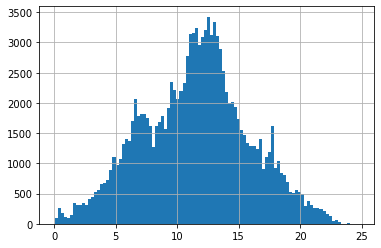

In [58]:
vis_data[vis_data.distance<25].distance.hist(bins=100)

## Поиск по распределению
[Источник](http://aqibsaeed.github.io/2016-07-17-anomaly-detection/)

Еще один способ найти выбросы - построить нормальное распределение поверх данных, посчитать вероятность находиться в данном распределении для каждого значения. Самые невероятные значения будем считать выбросами.

In [74]:
from scipy.stats import norm

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def get_gaussian(mu, sigma):
    distribution = norm(mu, sigma)
    return distribution

def get_probs(distribution, dataset):
    return distribution.pdf(dataset)

In [60]:
mu, sigma = estimate_gaussian(vis_data.distance.dropna())
distribution = get_gaussian(mu, sigma)
probabilities = get_probs(distribution, vis_data.distance.dropna())

Мы построили нормальное распределение на предоставленных данных и посчитали вероятность появления данной точки при данном распределении для каждого значения. Теперь выберем разумное значение вероятности, ниже которой будем считать точку выбросом. Например, `0.014`:

In [61]:
o_1 = np.where(probabilities < 0.014)[0]

In [62]:
len(o_1)

58

## DBSCAN

Алгоритм кластеризации DBSCAN определяет группы (кластеры) объектов. Его особенностью является то, что кроме самих кластеров он хорошо находит отдельно стоящие элементы, "шум". Применим его для нахождения выбросов. 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

`DBSCAN` работает очень медленно, поэтому мы возьмем не все данные:

In [ ]:
vis_data.shape

In [ ]:
normalized_dist = np.random.choice(vis_data.distance.dropna().values, 
                                   50000).reshape(-1, 1)

In [ ]:
db = DBSCAN(eps=0.5, min_samples=10).fit(normalized_dist)

Проверим количество выбросов:

In [ ]:
len(np.where(db.labels_ == -1)[0])

## Проблемы с выбросами

Несмотря на то, что выбросы "портят" общую картину и заставляют статистики в данных (например, среднее) выглядеть неправильно, иногда они очень важны:

 - Если мы занимаемся поиском аномалий (Anomaly Detection), выбросы являются нашими зависимыми переменными, которые необходимо найти, а не значениями, которые нужно выбросить. Поиск аномалий выходит за рамки курса
 - Как можно было понять из методов выше, нет однозначного способа понять, что перед нами выброс. Разные методы возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично. Кроме этого, разные параметры дают разные результаты и эти параметры необходимо крутить руками. Из-за этого найденные выбросы является крайне субъективным результатом

Дана небольшая выборка: [1, 39, 2, 1, 101, 2, 1, 100, 1, 3, 101, 1, 3, 100, 101, 100, 100]. Можно ли считать число 39 выбросом?

In [64]:
y = [1, 39, 2, 1, 101, 2, 1, 100, 1, 3, 101, 1, 3, 100, 101, 100, 100]

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

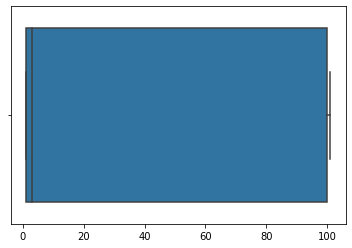

In [65]:
sns.boxplot(y)

In [67]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    o_1 = outliers_z_score(y, threshold=3)
o_1

array([], dtype=int64)

In [68]:
o_2 = outliers_iqr(y)
o_2

array([], dtype=int64)

In [73]:
mu, sigma = estimate_gaussian(y)
distribution = get_gaussian(mu, sigma)
probabilities = get_probs(distribution, y)

o_3 = np.where(probabilities < 0.014)[0]
o_3

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

Загрузите данные train.csv, найдите признак, обозначающий баланс. Уберите пропуски из этого признака и найдите выбросы с помощью межквартильного расстояния. Найдите модуль разницы между минимальным и максимальным среди значений, которые остались после удаления выбросов.

In [94]:
o = outliers_iqr(vis_data.balance_due.dropna())
o

array([     6,      9,     12, ..., 250259, 250274, 250287], dtype=int64)

In [89]:
new_balance = vis_data.balance_due.iloc[(~o)]
new_balance

250299      0.0
250296      0.0
250293    250.0
250292      0.0
250291      0.0
          ...  
48        200.0
47        305.0
46         25.0
31        305.0
18         10.0
Name: balance_due, Length: 9833, dtype: float64

In [98]:
vis_data.balance_due.iloc[o]

6          855.0
9          855.0
12         855.0
13         855.0
14         855.0
           ...  
250257    1130.0
250258    1130.0
250259    1130.0
250274    1130.0
250287    1130.0
Name: balance_due, Length: 9833, dtype: float64

In [97]:
vis_data.balance_due.iloc[~o]

250299      0.0
250296      0.0
250293    250.0
250292      0.0
250291      0.0
          ...  
48        200.0
47        305.0
46         25.0
31        305.0
18         10.0
Name: balance_due, Length: 9833, dtype: float64

In [105]:
df = pd.DataFrame(vis_data.balance_due.dropna())
df['outliers'] = 0
df.head(15)

,balance_due,outliers
0,305.0,0
1,75.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,305.0,0
6,855.0,0
7,140.0,0
8,140.0,0
9,855.0,0


In [106]:
df.loc[o, 'outliers'] = 1
df.head(15)

,balance_due,outliers
0,305.0,0
1,75.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,305.0,0
6,855.0,1
7,140.0,0
8,140.0,0
9,855.0,1


In [107]:
df[df.outliers == 0].balance_due.max() - df[df.outliers == 0].balance_due.min()

1201.3